This notebook tries B-VAE from https://arxiv.org/pdf/1804.03599.pdf


## Notes

If it stalls around loss 60, you might need a smaller batch size, e.g. 8



## Log

### 20180506
Why is this not working? It stalls around loss=60 and just reconstructs the same mean image each time.

- batchnorm and pad? no lots of other models use them
    - https://github.com/josephsmann/UnsupervisedDeepLearning-Pytorch/blob/jm/udlp/autoencoder/convVAE.py#L19
    - https://github.com/taey16/pix2pixBEGAN.pytorch/blob/master/models/BEGAN.py
- relu, same
- lr - similar to other models
- inner params - similar but larger than other working models
- batch? Maybe it seems better with a lower batch (e.g. 8 instead of 32)
- loss, this seems right
    - except some people use a loss balance https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/vae/arch.py#L97
        where they multuply reconstruction loss by 10 but i've got ~100 vs ~1e-4 so I don't really need to!
        
- ok a lower batch size seemed to get it over that initial hump

In [1]:
import os
os.sys.path.append('.')

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from vae import VAE6, loss_function_vae
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import load_cache_data
from helpers.samplers import SequenceInChunkSampler
from rnn import MDNRNN
import config

In [5]:
env_name='sonic256'

cuda= torch.cuda.is_available()

num_epochs=200
image_size=256
chunksize=1000
batch_size=6
action_dim = 12
seq_len = 1
gamma = 0.25
data_cache_file = os.path.join(config.base_vae_data_dir, 'sonic_rnn_256_v2.hdf5')

# Load data

In [6]:
loader_train, loader_test = load_cache_data(
    basedir=config.base_vae_data_dir, 
    env_name='sonic256', 
    data_cache_file=data_cache_file, 
    image_size=image_size, 
    chunksize=chunksize, 
    action_dim=action_dim,
    batch_size=batch_size,
    seq_len=seq_len
)
loader_train, loader_test

(<torch.utils.data.dataloader.DataLoader at 0x7f85a7ce70f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f85a7ce7668>)

In [7]:
[x.dtype for x in next(iter(loader_train))]

[torch.float32, torch.uint8, torch.float32, torch.uint8]

# View model

In [8]:

vae = VAE6(image_size=image_size, z_dim=128, conv_dim=64, code_dim=4, k_dim=256)
if cuda:
    vae.cuda()
    

# vae = VAE3(image_size=image_size, z_dim=8, conv_dim=64, code_dim=32, k_dim=512)
# if cuda:
#     vae.cuda()


In [9]:
# # Resume?
NAME='VAE6_6_256im_512z_CVAE'
save_file = './models/{NAME}_state_dict.pkl'.format(NAME=NAME)
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print('loaded {save_file}'.format(save_file=save_file))

In [10]:
img = np.random.randn(image_size, image_size, 3)
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    print(x.size())
    print(loss_function_vae(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
    
del x, mu, logvar, gpu_img, img
    
df[df.level<2]

torch.Size([1, 3, 256, 256])
(tensor(1.00000e+05 *
       [ 2.4666], device='cuda:0'), tensor([ 0.3312], device='cuda:0'))
Total parameters 22320063
Total trainable parameters 22320063


,name,class_name,input_shape,output_shape,nb_params,level
4,encoder.0,BasicConv2d,"[(-1, 3, 256, 256)]","[(-1, 64, 256, 256)]",1920,1
42,encoder.1,ConvBlock5,"[(-1, 64, 256, 256)]","[(-1, 128, 128, 128)]",165340,1
80,encoder.2,ConvBlock5,"[(-1, 128, 128, 128)]","[(-1, 192, 64, 64)]",499000,1
118,encoder.3,ConvBlock5,"[(-1, 192, 64, 64)]","[(-1, 256, 32, 32)]",1005460,1
156,encoder.4,ConvBlock5,"[(-1, 256, 32, 32)]","[(-1, 320, 16, 16)]",1684720,1
194,encoder.5,ConvBlock5,"[(-1, 320, 16, 16)]","[(-1, 384, 8, 8)]",2536780,1
232,encoder.6,ConvBlock5,"[(-1, 384, 8, 8)]","[(-1, 448, 4, 4)]",3561640,1
270,encoder.7,ConvBlock5,"[(-1, 448, 4, 4)]","[(-1, 128, 4, 4)]",898564,1
271,mu,Linear,"[(-1, 2048)]","[(-1, 256)]",524544,0
272,logvar,Linear,"[(-1, 2048)]","[(-1, 256)]",524544,0


## Train

In [11]:
import collections

def train(loader, net, optimizer, loss_function_vae, test=False, cuda=True):
    if test:
        net.eval()
    else:
        net.train()
    info = collections.defaultdict(list)
    
    with tqdm(total=len(loader)*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i, (observations, actions, rewards, dones) in enumerate(loader):
            x = Variable(observations.transpose(1,3))
            if cuda:
                x=x.cuda()
            y, mu, logvar = vae.forward(x)
            loss_recon, loss_KLD = loss_function_vae(y, x, mu, logvar)
            loss = loss_recon + gamma * torch.abs(loss_KLD-C)
            loss = loss.mean() # mean along the batches
            
            info['loss'].append(loss.cpu().data.item())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            if not test:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            prog.update(loader.batch_size)
            prog.desc='loss={loss:2.2f} [ {loss_recon:2.2f} + {rhs:2.2f}={loss_recon:2.2f} + {gamma}*|{loss_KLD:2.2f} - {C}| ]'.format(
                loss=np.mean(info['loss']),
                loss_recon=np.mean(info['loss_recon']),
                gamma=gamma,
                C=C,
                loss_KLD=np.mean(info['loss_KLD']),
                rhs = gamma*np.abs(np.mean(info['loss_KLD'])-C)
            )
            if i==100:
                print(prog.desc)
        print(prog.desc)
        prog.close()
    return info

In [12]:
# Plot reconstructions
def plot_results(loader=loader_test, n=2, epoch=0):
    x, actions, rewars, dones = next(iter(loader))

    X = Variable(x).transpose(1,3).contiguous()
    if cuda:
        X = X.cuda()
    Y, mu, logvar = vae.forward(X)
    loss_recon, loss_KLD = loss_function_vae(Y, X, mu, logvar)
    loss = loss_recon + gamma * torch.abs(loss_KLD-C)

    y=Y.cpu().data.transpose(1,3).numpy()
    for i in range(n):
        plt.figure(figsize=(6,3))
        plt.subplot(1, 2, 1)
        plt.title('original')
        plt.axis('off')
        plt.imshow(x[i].numpy())

        plt.subplot(1, 2, 2)
        plt.imshow(y[i])
        plt.axis('off')
        plt.title('reconstructed')

        plt.suptitle('epoch {}, index {}, loss {:2.4f}'.format(epoch, i, loss[i].cpu().data.numpy()))
        plt.show()
        
    del y
    del Y
    del X
    del x
    del mu
    del logvar
    del loss
        
# plot_results(loader=loader_test, n=2, epoch=epoch)

In [13]:
# Train
optimizer = optim.Adam(vae.parameters(), lr=3e-4)
import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [14]:
histories=[]
C = 0
C_epoch_inc = 10 # How much to increase C by each epoch

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


loss=17999.27 [ 17967.55 + 31.73=17967.55 + 0.25*|126.90 - 0| ]
loss=11817.57 [ 11756.19 + 61.38=11756.19 + 0.25*|245.51 - 0| ]



loss=19504.60 [ 19447.57 + 57.02=19447.57 + 0.25*|228.10 - 0| ]
loss=14701.06 [ 14640.26 + 60.79=14640.26 + 0.25*|243.16 - 0| ]

Epoch 0, loss=11817.5689, loss_val=14701.0555


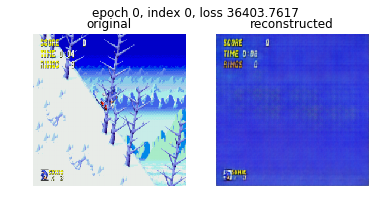

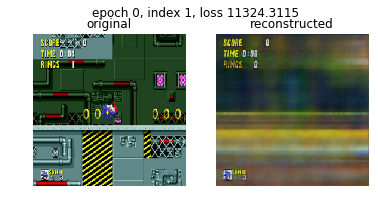

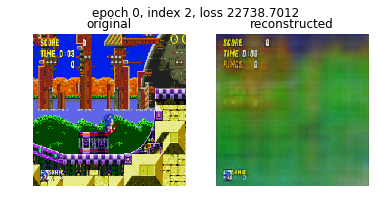

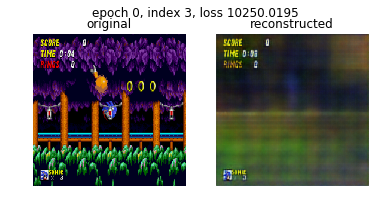

loss=9307.65 [ 9248.18 + 59.47=9248.18 + 0.25*|247.87 - 10| ]



KeyboardInterrupt: 

In [15]:
for epoch in range(num_epochs): 
    info = train(loader_train, vae, optimizer, loss_function_vae, test=False, cuda=True)
    info_val = train(loader_test, vae, optimizer, loss_function_vae, test=True, cuda=True)
    scheduler.step(np.mean(info_val['loss']))
    
    C += C_epoch_inc
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}'.format(epoch, np.mean(info['loss']), np.mean(info_val['loss'])))
    
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    plot_results(loader=loader_test, n=4, epoch=epoch)
    torch.save(vae.state_dict(), './models/{NAME}_{epoch}_state_dict.pkl'.format(NAME=NAME, epoch=epoch))

le=1e-4... no diff
- Epoch 0, C=100  
    - loss=2770.8355, loss_val=3994.2864 
    - loss=4080.66=3783.20 + 297.46=3783.20 + 1*|397.46 - 100| 

lr=1e-3
- Epoch 0, C=100  
    - loss=2893, loss_val ~3000
    - loss=2919.68=2674.58 + 245.09=2674.58 + 1*|345.09 - 100|
    
lr=1e-3
- Epoch 0, C=400  
    - loss=3921.11 [ 3887.67 + 28.48=3887.67 + 1*|428.48 - 400| ]
    - loss=2560.1797, loss_val=3921.1070
- Epoch 1,  C=600
    - loss=2383.9083, loss_val=3785.8459
    - loss=2801.65 [ 2789.71 + 6.43=2789.71 + 1*|606.43 - 600| ]
    - loss=3785.85 [ 3771.32 + 3.96=3771.32 + 1*|603.96 - 600| ]



/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


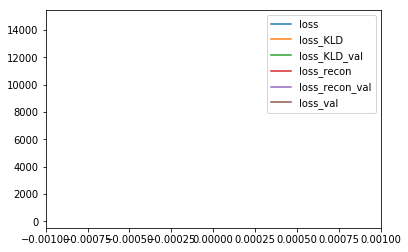

In [16]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()

In [1]:
torch.save(vae.state_dict(), './models/{NAME}_state_dict.pkl'.format(NAME=NAME))
torch.save(vae, './models/{NAME}.pkl'.format(NAME=NAME))
df_history.to_csv('./models/{NAME}.csv'.format(NAME=NAME), index=False)

NameError: name 'torch' is not defined

In [18]:
# import pandas as pd
# pd.read_csv(f'./models/{NAME}.csv').to_dict('split')

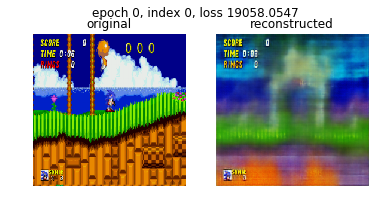

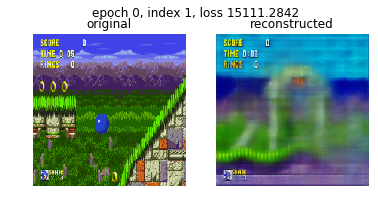

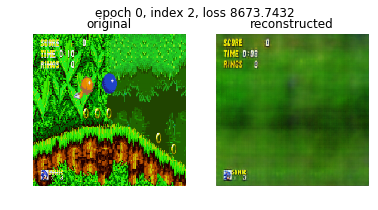

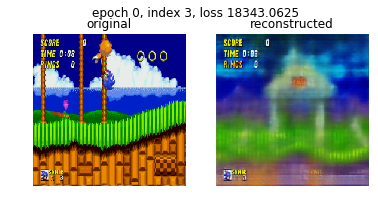

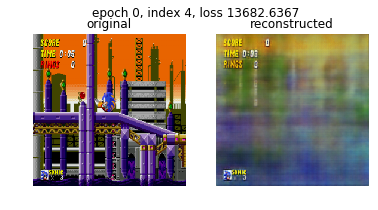

In [19]:
torch.cuda.empty_cache()
plot_results(loader=loader_test, n=5, epoch=0)

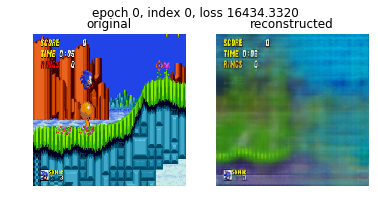

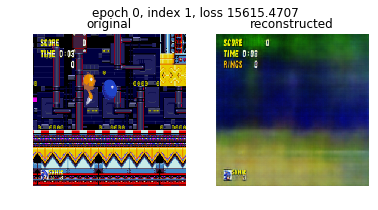

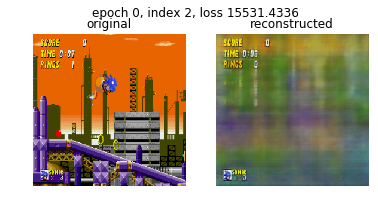

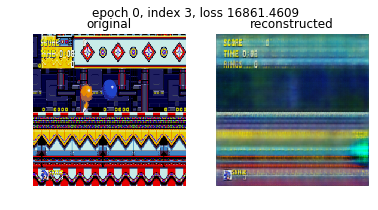

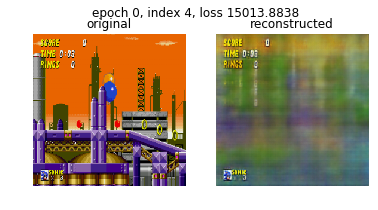

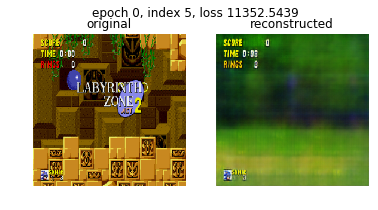

In [20]:
plot_results(loader=loader_train, n=6, epoch=0)

# End

In [ ]:
%time x=data_test[500]

In [ ]:
# DEBUG check chunk size
# should be less than 1e9
# should take more than 100ms, less than 1s
import itertools
x=data_train
shapes = list(itertools.product(*x.chunks))
nbytes = [x.dtype.itemsize * np.prod(shape) for shape in shapes]
assert nbytes[0]<1e9
nbytes[0]